In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold


PATH = "Data/"
SEED = 11223

In [2]:
X_train = pd.read_csv(PATH + "X_train.csv", index_col=[0])
X_test = pd.read_csv(PATH + "X_test.csv", index_col=[0])
y_train = pd.read_csv(PATH + "y_train.csv", index_col=[0])
y_test = pd.read_csv(PATH + "y_test.csv", index_col=[0])

y_train = y_train["Country"].copy()
y_test = y_test["Country"].copy()

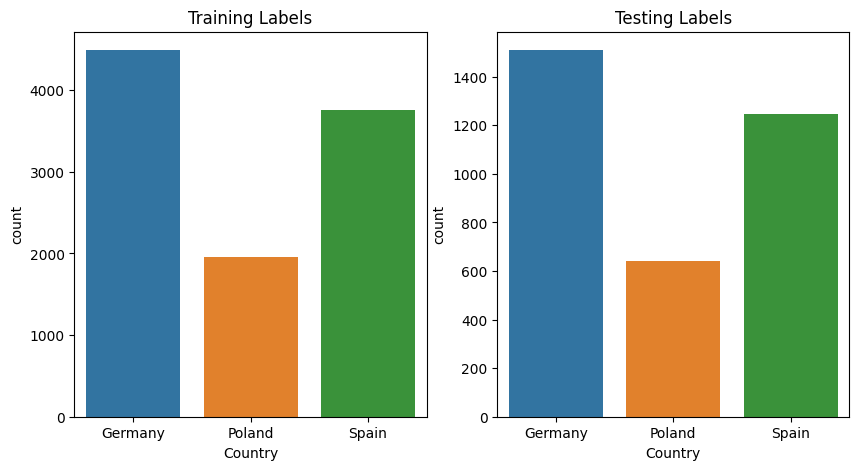

In [3]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

sns.countplot(x = y_train, ax = ax[0]).set_title('Training Labels')
sns.countplot(x = y_test, ax = ax[1], order = ['Germany', 'Poland', 'Spain']).set_title('Testing Labels')
plt.show()

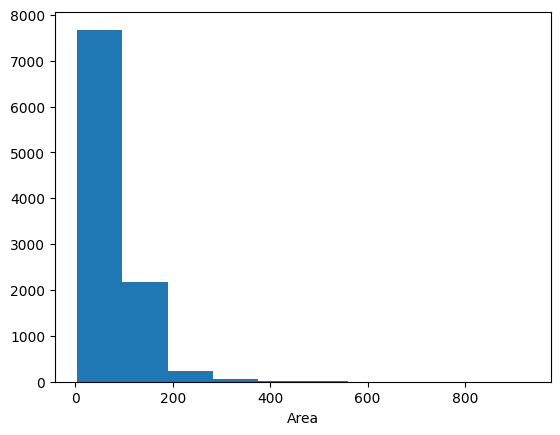

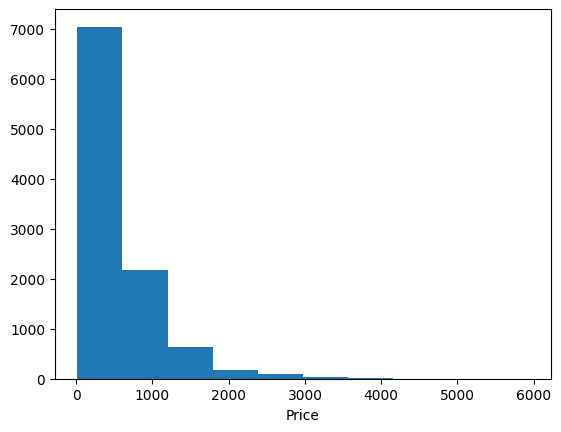

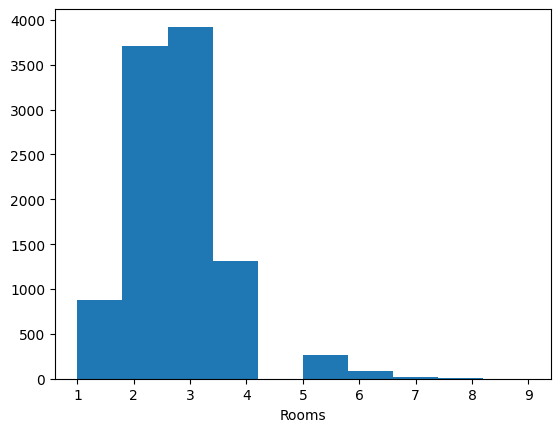

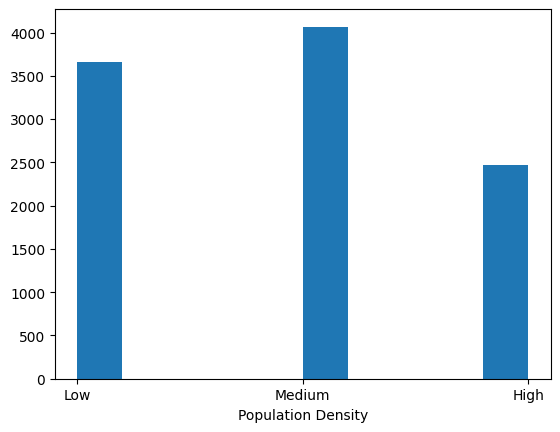

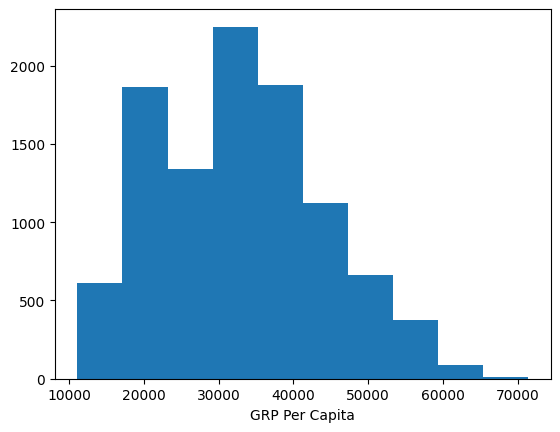

In [4]:
for col in range(X_train.shape[1]):
    plt.hist(X_train.iloc[:, col])
    plt.xlabel(X_train.columns[col])
    plt.show()

<Axes: >

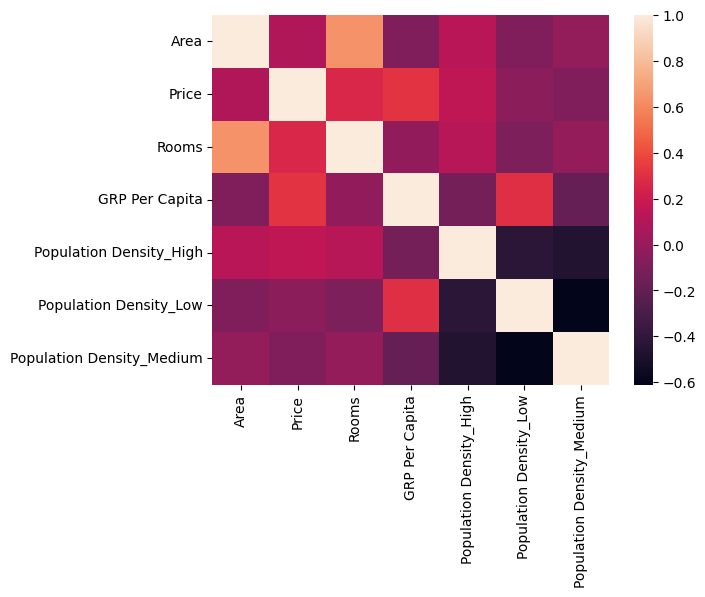

In [5]:
X_train = pd.get_dummies(X_train, dtype = int)
X_test = pd.get_dummies(X_test, dtype = int)

sns.heatmap(X_train.corr())

In [6]:
np.where(X_train.duplicated() == True)

(array([], dtype=int64),)

In [7]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)

lda = LinearDiscriminantAnalysis()
X_train = pd.get_dummies(X_train, dtype = int)
X_train_lda = pd.DataFrame(lda.fit_transform(X_train, y_train_le), columns = ['LDA 1', 'LDA 2'])

X_train_lda["Country"] = y_train_le

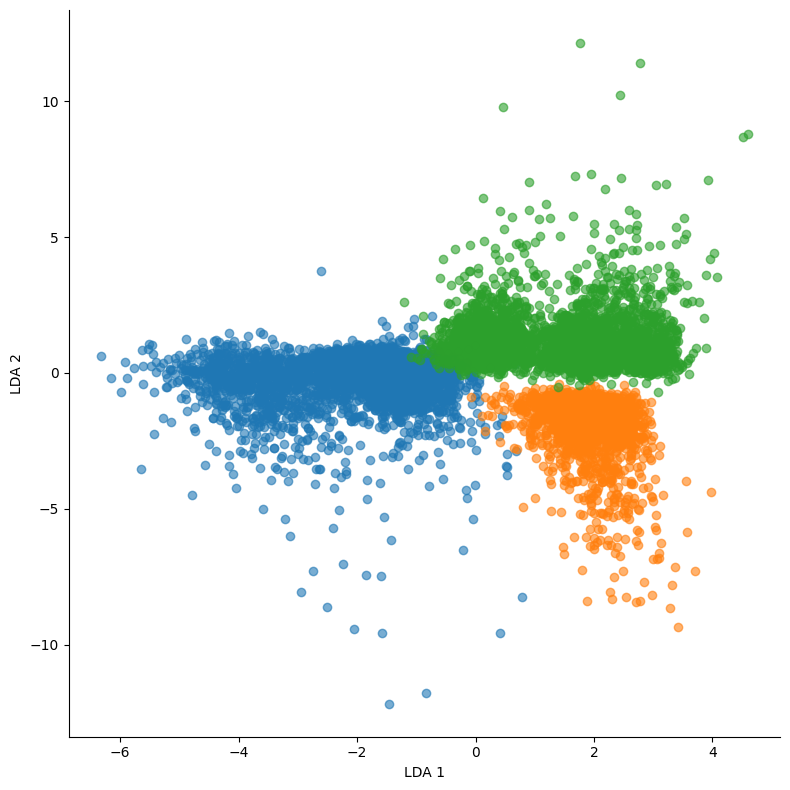

In [8]:
sns.FacetGrid(X_train_lda, hue = 'Country', height = 8).map(plt.scatter, 'LDA 1', 'LDA 2', alpha = 0.6)
plt.show()

In [9]:
lda.fit(X_train, y_train)
lda.explained_variance_ratio_

array([0.71538612, 0.28461388])

Very high separability between classes (based on some combination of available features)

## Models

### Logistic Regression

In [10]:
log_reg = LogisticRegression(class_weight = 'balanced', multi_class = 'ovr', random_state = SEED)
log_reg_params = [{'LogisticRegression__tol': [0.1, 0.001, 0.0001], 'LogisticRegression__C': [0.1, 1., 5.], 
                   'LogisticRegression__solver': ['lbfgs', 'newton-cg']}]
pipe = Pipeline([('scaler', StandardScaler()), ('LogisticRegression', log_reg)])
lr = GridSearchCV(pipe, log_reg_params, scoring = 'f1_weighted')

lr.fit(X_train, y_train)
lr.best_score_

0.9987264678078744

In [11]:
lr_pred = lr.predict(X_test)
lr_f1 = round(f1_score(y_test, lr_pred, average = 'weighted'), 3)

lr_pred_prob = lr.predict_proba(X_test)
lr_auc = round(roc_auc_score(y_test, lr_pred_prob, multi_class = "ovr", average = "weighted"), 3)

print(lr_f1)
print(lr_auc)

0.998
1.0


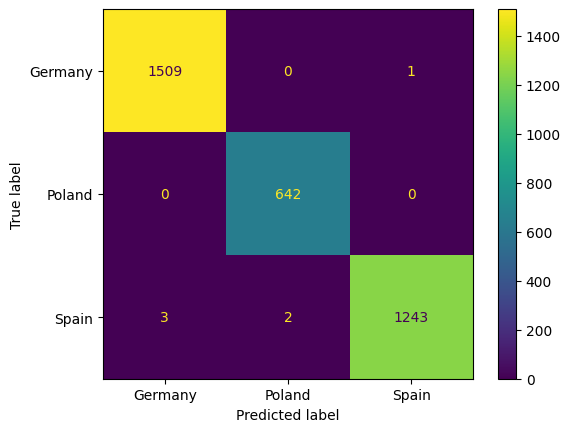

In [12]:
ConfusionMatrixDisplay.from_predictions(y_test, lr_pred)

In [13]:
#lr.best_estimator_.named_steps.LogisticRegression.coef_

#lr.best_estimator_.named_steps.LogisticRegression.classes_

#X_train.columns

# Germany = 0, Poland = 1, Spain = 2

##### Plot ROC Curve

In [14]:
label_binarizer = LabelBinarizer().fit(y_test)
y_onehot_test = label_binarizer.transform(y_test)
#y_onehot_test.shape

def plot_roc_curve(class_of_interest, prediction, model):
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        prediction[:, class_id],
        name = f"{class_of_interest} vs Other Classes",
        color = "dodgerblue"
    )
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("One-vs-Rest ROC curves:\n{} vs Other Classes".format(class_of_interest))
    plt.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Guideline')
    plt.legend()

    #plt.savefig(PATH + "Results/{}.png".format(model + "_" + class_of_interest))
    plt.show()

    
#plot_roc_curve("Germany", lr_pred_prob, "log_reg")
#plot_roc_curve("Poland", lr_pred_prob, "log_reg")
#plot_roc_curve("Spain", lr_pred_prob, "log_reg")

### Random Forest

In [15]:
#X_train.shape[0]*0.05

kfold = KFold(shuffle = True, random_state = SEED)
parameters = {'RandomForest__min_samples_leaf':[250, 500, 1000]}
randfor = RandomForestClassifier(class_weight = 'balanced', max_depth = 5, random_state = SEED)
pipe2 = Pipeline([('scaler', StandardScaler()), ('RandomForest', randfor)])
rf = GridSearchCV(pipe2, parameters, cv = kfold, scoring = 'f1_weighted')

rf.fit(X_train, y_train)
rf.best_params_

{'RandomForest__min_samples_leaf': 250}

In [16]:
rf_pred = rf.predict(X_test)
rf_f1 = round(f1_score(y_test, rf_pred, average = 'weighted'), 3)

rf_pred_prob = lr.predict_proba(X_test)
rf_auc = round(roc_auc_score(y_test, rf_pred_prob, multi_class = "ovr", average = "weighted"), 3)

print(rf_f1)
print(rf_auc)

0.986
1.0


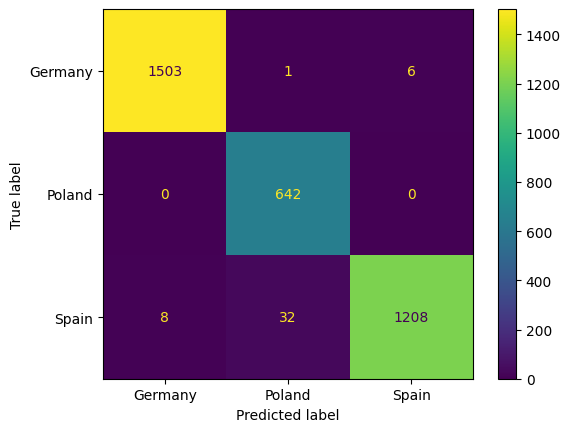

In [17]:
ConfusionMatrixDisplay.from_predictions(y_test, rf_pred)

In [18]:
#plot_roc_curve("Germany", rf_pred_prob, "rand_forest")
#plot_roc_curve("Poland", rf_pred_prob, "rand_forest")
#plot_roc_curve("Spain", rf_pred_prob, "rand_forest")

In [19]:
gdgfgfd

NameError: name 'gdgfgfd' is not defined

### SVC

In [ ]:
parameters = {'estimator__C': [0.1, 1, 10]} #, 'estimator__gamma':[1, 10, 25], 'estimator__kernel': ['poly', 'rbf']}

svc = OneVsRestClassifier(SVC(kernel = 'linear', random_state = SEED, probability = True))
best_svc = GridSearchCV(svc, param_grid = parameters, cv = kfold)

best_svc.fit(X_train, y_train)
best_svc.best_params_

Notes:
German data all pre-covid, Polish data all post covid, Spanish data no date information (source just notes post covid)